In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn import model_selection
from sklearn.metrics import mean_absolute_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.svm import SVC

Baseline - 70~ percent before datatype

In [66]:
df = pd.read_csv("outputs\songs.csv")

# print(list(df.columns))
# df

In [67]:
X = df.iloc[:, 3:17]
Y = df.liked

# df.liked.hist()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

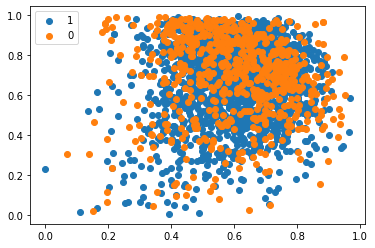

In [68]:
X = np.array(X)
Y = np.array(Y)
counter = Counter(Y)
for label, _ in counter.items():
	row_ix = np.where(Y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [69]:
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('LogR', LogisticRegression()))
models.append(('LogRCV', LogisticRegressionCV()))
models.append(('SVM', SVC()))

In [70]:
seed = 10
k_splits = 13

In [71]:
results0 = []
names0 = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=k_splits, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    results0.append(cv_results)
    names0.append(name)
    print(f"{name} \t Mean: {cv_results.mean()}\t Std: {cv_results.std()}")

CART 	 Mean: 1.0	 Std: 0.0
NB 	 Mean: 0.767425063199711	 Std: 0.022221191856865517
KNN 	 Mean: 0.735283495846876	 Std: 0.026656037684717845
LDA 	 Mean: 0.7717587576742507	 Std: 0.026207009832469094
LogR 	 Mean: 0.7829541350668111	 Std: 0.06398011692925978
LogRCV 	 Mean: 0.7670639219934995	 Std: 0.027532132253587447
SVM 	 Mean: 0.7663416395810763	 Std: 0.025592658312064375


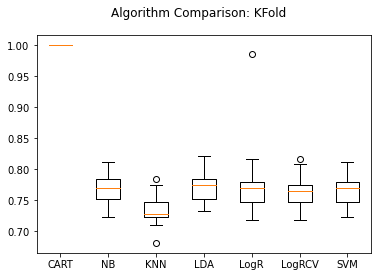

In [72]:
fig0 = plt.figure()
fig0.suptitle('Algorithm Comparison: KFold')
ax = fig0.add_subplot(111)
plt.boxplot(results0)
ax.set_xticklabels(names0)
plt.show()

In [73]:
results1 = []
names1 = []

for name, model in models:
    skfold = model_selection.StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='accuracy')
    results1.append(cv_results)
    names1.append(name)
    print(f"{name} \t Mean: {cv_results.mean()}\t Std: {cv_results.std()}")

CART 	 Mean: 1.0	 Std: 0.0
NB 	 Mean: 0.7688696280245575	 Std: 0.015533270615822728
KNN 	 Mean: 0.7295052365474903	 Std: 0.025618126184136076
LDA 	 Mean: 0.771397616468039	 Std: 0.013200192764533818
LogR 	 Mean: 0.7854821235102926	 Std: 0.05131001938270012
LogRCV 	 Mean: 0.765619357168653	 Std: 0.0012510298357304886
SVM 	 Mean: 0.7667027807872877	 Std: 0.004273080377825636


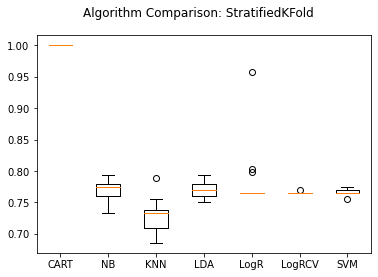

In [74]:
fig1 = plt.figure()
fig1.suptitle('Algorithm Comparison: StratifiedKFold')
ax = fig1.add_subplot(111)
plt.boxplot(results1)
ax.set_xticklabels(names1)
plt.show()

In [75]:
results2 = []
names2 = []

for name, model in models:
    rskfold = model_selection.RepeatedStratifiedKFold(n_splits=k_splits, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=rskfold, scoring='accuracy')
    results2.append(cv_results)
    names2.append(name)
    print(f"{name} \t Mean: {cv_results.mean()}\t Std: {cv_results.std()}")

CART 	 Mean: 1.0	 Std: 0.0
NB 	 Mean: 0.7681473456121344	 Std: 0.013561801998849222
KNN 	 Mean: 0.7342000722282412	 Std: 0.019308055826604952
LDA 	 Mean: 0.7711448176236908	 Std: 0.01248008076847731
LogR 	 Mean: 0.7839292163235824	 Std: 0.052513967366030194
LogRCV 	 Mean: 0.7788010111953774	 Std: 0.04575083272803451
SVM 	 Mean: 0.7665583243048031	 Std: 0.003907007103300391


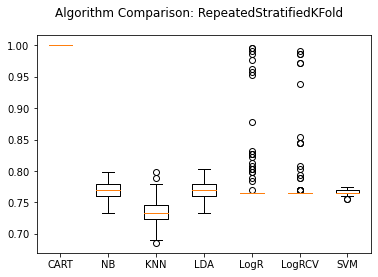

In [76]:
fig2 = plt.figure()
fig2.suptitle('Algorithm Comparison: RepeatedStratifiedKFold')
ax = fig2.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()